# Sourcing and Cleaning IMDB Data

In [2]:
#import all programs needed
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#establish connection to imdb database

conn = sqlite3.connect('Phase 1 Project Data/im.db')
cursor_obj = conn.cursor()

In [5]:
#create movie_basics dataframe and examine the data 
movie_basics_df = pd.read_sql('''
    SELECT *
    FROM movie_basics
    ''', conn)

movie_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


Notes on movie_basics: Missing data in the original_title column (<1%), genres (4%) and runtime_minutes (21%). Nulls in title and genre are better to drop, while runtime should be inputed based on mean or median. 

Data types make sense 

Genres is a string containing multiple genres. Needs to be split into multiple columns. Possibly use a primary/secondary/tertiary genre structure based on the order it is listed in the string 

In [13]:
#create movie_ratings dataframe and examine the data
movie_ratings_df = pd.read_sql('''
    SELECT *
    FROM movie_ratings
    ''', conn)

movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


Notes on movie_rating dataframe: only two columns. Wide range in the number of votes, possibly need to create a minimum vote count to be included in the ratings analysis (mean - 3*std).

Possible outliers included. The minimum average rating is more than 3 standard deviations away from the mean. The std of the numvotes column is an order of magnitude greater than the mean.

Smaller than the movie_basics dataframe so it would make sense to merge left onto the basics df 

In [15]:
#create director dataframe and examine data
director_df = pd.read_sql('''
    SELECT *
    FROM directors
    ''', conn)

director_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


Only contains the person_id for the director, if I want names then I will have to merge with the persons dataframe. Otherwise looks good with no null values 

In [16]:
#create persons dataframe and examine data
persons_df = pd.read_sql('''
    SELECT *
    FROM persons
    ''', conn)

persons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


Need to concat with directors df in order to create a full list of movie ids with director names 

In [34]:
#merge director and persons dataframes to create a unified df of director credits with names 

director_persons_df = pd.merge(director_df, persons_df, how = 'left', on = 'person_id')
director_persons_df.info()

#remove duplicates before merging with movie_basics_ratings

director_persons_df.drop_duplicates(subset = 'movie_id', inplace = True)
director_persons_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 291174 entries, 0 to 291173
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            291174 non-null  object 
 1   person_id           291174 non-null  object 
 2   primary_name        291171 non-null  object 
 3   birth_year          68608 non-null   float64
 4   death_year          1738 non-null    float64
 5   primary_profession  290187 non-null  object 
dtypes: float64(2), object(4)
memory usage: 15.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 140417 entries, 0 to 291173
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            140417 non-null  object 
 1   person_id           140417 non-null  object 
 2   primary_name        140416 non-null  object 
 3   birth_year          30609 non-null   float64
 4   death_year          85

In [31]:
#merge movie ratings and movie basics dfs together 

movie_basics_ratings_df = pd.merge(movie_basics_df, movie_ratings_df, how ='left', on = 'movie_id')
movie_basics_ratings_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 146144 entries, 0 to 146143
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
 6   averagerating    73856 non-null   float64
 7   numvotes         73856 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 10.0+ MB


In [121]:
#create final IMDB database by merging movie_basics_ratings_df left onto director_persons_df 
imdb_df = pd.merge(director_persons_df, movie_basics_ratings_df, how = 'left', on = 'movie_id')

In [122]:
#clean up the IMDB dataframe (rename primary name, remove birth year and death year, remove rows with null name, primary profession and genres)
imdb_df.rename(columns = {'primary_name':'director_name'}, inplace = True)
imdb_df.drop(columns = ['birth_year', 'death_year'], axis = 1, inplace = True)
imdb_df.dropna(subset = ['director_name', 'primary_profession', 'original_title', 'genres'], axis = 0, inplace = True)

In [123]:
#Remove potential duplicate titles by sorting for and removing rows with duplicate titles and directors. Keep the row with highest number of votes
imdb_df.sort_values(by = ['primary_title', 'director_name', 'numvotes'], ascending = [True, True, False], inplace = True)
imdb_df.drop_duplicates(subset = ['primary_title', 'director_name'], keep = 'first', inplace = True)


In [134]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136409 entries, 8464 to 72703
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            136409 non-null  object 
 1   person_id           136409 non-null  object 
 2   director_name       136409 non-null  object 
 3   primary_profession  136409 non-null  object 
 4   primary_title       136409 non-null  object 
 5   original_title      136409 non-null  object 
 6   start_year          136409 non-null  int64  
 7   runtime_minutes     109720 non-null  float64
 8   genres              136409 non-null  object 
 9   averagerating       72345 non-null   float64
 10  numvotes            72345 non-null   float64
dtypes: float64(3), int64(1), object(7)
memory usage: 12.5+ MB


# Combining IMDB and Budget Data 

In [157]:
budget_df = pd.read_csv('budget_df.csv')

In [166]:
#Merge IMDB with Budget. Create a subset of only movies with matching release years

merged_df = budget_df.merge(imdb_df, how = 'left', left_on = 'movie', right_on = 'primary_title')
imdb_budget_df = merged_df[merged_df['start_year'] == merged_df['release_year']]
imdb_budget_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1536 entries, 1 to 7075
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1536 non-null   int64  
 1   id                  1536 non-null   int64  
 2   release_date        1536 non-null   object 
 3   movie               1536 non-null   object 
 4   production_budget   1536 non-null   int64  
 5   domestic_gross      1536 non-null   int64  
 6   worldwide_gross     1536 non-null   int64  
 7   profit              1536 non-null   int64  
 8   release_month       1536 non-null   int64  
 9   foreign_gross       1536 non-null   int64  
 10  release_year        1536 non-null   int64  
 11  ROI                 1536 non-null   float64
 12  movie_id            1536 non-null   object 
 13  person_id           1536 non-null   object 
 14  director_name       1536 non-null   object 
 15  primary_profession  1536 non-null   object 
 16  primar

In [167]:
#Separate genres into individual rows
imdb_budget_df['genres'] = imdb_budget_df['genres'].apply(lambda x: str(x).split(','))
imdb_budget_df = imdb_budget_df.explode('genres')

<ipython-input-167-009832f8539f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_budget_df['genres'] = imdb_budget_df['genres'].apply(lambda x: str(x).split(','))


In [169]:
imdb_budget_df

,Unnamed: 0,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,release_month,foreign_gross,...,person_id,director_name,primary_profession,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
1,1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,5,804600000,...,nm0551128,Rob Marshall,"director,miscellaneous,producer",Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011.0,136.0,Action,6.6,447624.0
1,1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,5,804600000,...,nm0551128,Rob Marshall,"director,miscellaneous,producer",Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011.0,136.0,Adventure,6.6,447624.0
1,1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,5,804600000,...,nm0551128,Rob Marshall,"director,miscellaneous,producer",Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011.0,136.0,Fantasy,6.6,447624.0
2,2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,6,107000000,...,nm1334526,Simon Kinberg,"producer,writer,director",Dark Phoenix,Dark Phoenix,2019.0,113.0,Action,6.0,24451.0
2,2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,6,107000000,...,nm1334526,Simon Kinberg,"producer,writer,director",Dark Phoenix,Dark Phoenix,2019.0,113.0,Adventure,6.0,24451.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7065,5751,52,2015-12-01,Dutch Kills,25000,0,0,-25000,12,0,...,nm3556672,Joseph Mazzella,"actor,producer,director",Dutch Kills,Dutch Kills,2015.0,90.0,Thriller,5.1,82.0
7072,5758,59,2011-11-25,The Ridges,17300,0,0,-17300,11,0,...,nm4192760,Brandon Landers,"actor,sound_department,art_department",The Ridges,The Ridges,2011.0,89.0,Drama,2.9,127.0
7072,5758,59,2011-11-25,The Ridges,17300,0,0,-17300,11,0,...,nm4192760,Brandon Landers,"actor,sound_department,art_department",The Ridges,The Ridges,2011.0,89.0,Horror,2.9,127.0
7072,5758,59,2011-11-25,The Ridges,17300,0,0,-17300,11,0,...,nm4192760,Brandon Landers,"actor,sound_department,art_department",The Ridges,The Ridges,2011.0,89.0,Thriller,2.9,127.0


# Use imdb_budget to find the most popular genres for peak months 

<AxesSubplot:xlabel='release_month', ylabel='profit'>

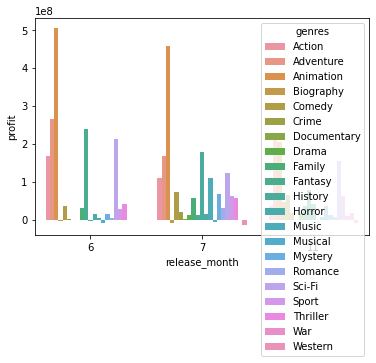

In [192]:
grouped_df = imdb_budget_df.groupby(['release_month', 'genres']).median().reset_index()
grouped_df_subset = grouped_df.loc[grouped_df['release_month'].isin([6,7,11])].reset_index()
sns.barplot(x = 'release_month', y ='profit', hue = 'genres', data = grouped_df_subset)